In [1]:
from googleapiclient.discovery import build
import pandas as pd
from googleapiclient.errors import HttpError

def youtube_search_and_comments(query):
    # Replace 'YOUR_API_KEY' with your actual YouTube Data API key
    api_key = ''
    youtube = build('youtube', 'v3', developerKey=api_key)

    # Perform the search
    search_response = youtube.search().list(
        q=query,
        part='snippet',
        maxResults=10000 # Number of results to display
    ).execute()

    # Initialize a list to hold comments
    all_comments = []
    # Fetch comments for each video
    try:
        for item in search_response['items']:
            if item['id']['kind'] == 'youtube#video':
                video_id = item['id']['videoId']
                
                # Initialize pagination
                comments_response = youtube.commentThreads().list(
                    part='snippet',
                    videoId=video_id,
                    maxResults=100,  # Set to a reasonable number per request
                ).execute()
    
                while True:
                    for comment in comments_response['items']:
                        text = comment['snippet']['topLevelComment']['snippet']['textDisplay']
                        all_comments.append({'video_id': video_id, 'comment': text})
                    
                    # Check if there's a next page
                    if 'nextPageToken' in comments_response:
                        comments_response = youtube.commentThreads().list(
                            part='snippet',
                            videoId=video_id,
                            maxResults=10000,
                            pageToken=comments_response['nextPageToken']
                        ).execute()
                    else:
                        break  # Exit loop if there are no more pages
                        
    
    except HttpError as e:
        if e.resp.status == 403 and "commentsDisabled" in str(e):
            print(f"Comments are disabled for video ID: {video_id}.")
        else:
            print(f"An error occurred while fetching comments for video ID {video_id}: {e}")
    df = pd.DataFrame(all_comments)

    # Save the DataFrame to a CSV file
    df.to_csv('youtube_comments.csv', index=True)

    print("Comments saved to youtube_comments.csv")

if __name__ == "__main__":
    query = input("Enter a word to search on YouTube: ")
    youtube_search_and_comments(query)
    
    
        
    
        


Enter a word to search on YouTube:  Global warming


Comments are disabled for video ID: Y3gqoDUtmt4.
Comments saved to youtube_comments.csv


In [5]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
import nltk

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Informal language dictionary mapping informal terms to their expanded forms
informal_dict = {
    "lol": "laugh out loud",
    "omg": "oh my god",
    "btw": "by the way",
    "ttyl": "talk to you later",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "idk": "I don't know",
    "smh": "shaking my head",
    "fyi": "for your information"
}

# Function to standardize informal language
def standardize_informal_language(text):
    # Convert to lowercase for case-insensitive matching
    text = text.lower()
    
    # Replace informal terms with their standard equivalents
    for informal, formal in informal_dict.items():
        # Use word boundaries to ensure whole words are matched
        text = re.sub(r'\b' + re.escape(informal) + r'\b', formal, text)
    
    return text

# Function for text preprocessing
def text_preprocessing(text):
    # Standardize informal language before other preprocessing steps
    text = standardize_informal_language(text)

    # Remove specific patterns or unwanted characters
    text = re.sub(r'\boooooooooooooooooo\b', '', text)
    text = re.sub(r'\bbr\b', '', text)  # Remove standalone "br"
    text = re.sub(r'<br\s*/?>', ' ', text)  # Replace <br> tags with space
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    text = re.sub(r'\n+', ' ', text)  # Replace newlines with space
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters
    text = re.sub(r'https://\S+', '', text)  # Remove URLs
    text = re.sub(r'DOI: \S+', '', text)  # Remove DOI references
    text = re.sub(r'et al\.\S+', '', text)  # Remove "et al."
    text = text.strip()  # Strip leading/trailing whitespace
    text = re.sub(r'\bgt\b', '', text)
    text = re.sub(r'\bquot\b', '', text)  # Remove the word "quot"
    text = re.sub('[,\.!?]', '', text)  # Remove punctuation

    # Remove emojis using regex pattern
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Tokenization
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words

    return ' '.join(tokens)  # Join tokens back into a string

# Load the CSV file
df = pd.read_csv("youtube_comments.csv")

# Apply the text preprocessing to the 'comment' column
df['comment'] = df['comment'].apply(text_preprocessing)

# Function to get sentiment from TextBlob
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis
df['sentiment'] = df['comment'].apply(get_sentiment)

# Calculate the mean sentiment score
mean_sentiment = df['sentiment'].mean()

# Output the processed dataframe and mean sentiment score
print(df)
print(f"Mean Sentiment Score: {mean_sentiment}")


<>:55: SyntaxWarning: invalid escape sequence '\.'
<>:55: SyntaxWarning: invalid escape sequence '\.'
C:\Users\zobey\AppData\Local\Temp\ipykernel_21628\313100707.py:55: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('[,\.!?]', '', text)  # Remove punctuation
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zobey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


       Unnamed: 0     video_id  \
0               0  6ipKY5xqiec   
1               1  6ipKY5xqiec   
2               2  6ipKY5xqiec   
3               3  6ipKY5xqiec   
4               4  6ipKY5xqiec   
...           ...          ...   
13407       13407  sDS1sFg6lNw   
13408       13408  sDS1sFg6lNw   
13409       13409  sDS1sFg6lNw   
13410       13410  sDS1sFg6lNw   
13411       13411  sDS1sFg6lNw   

                                                 comment  sentiment  
0                     vw already jeopardy realize really   0.200000  
1      floods spain latest deposit alluvium city subu...   0.500000  
2                    copernicus confirmed today exceeded   0.400000  
3      finallya chance truth come climate frauds expo...   0.300000  
4      concept climate change belief people thats def...   0.000000  
...                                                  ...        ...  
13407  much see climate change global warming outside...   0.066667  
13408  thank simple clear crisp

In [54]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud 


# Download the stopwords from NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Assuming 'cm()' is a function that returns a list of words
cm = df['comment'].tolist()


# Create a set of English stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from the list
filtered_list = [word for word in cm if word.lower() not in stop_words]

# 'filtered_list' now contains the list without stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=1000, contour_width=2, contour_color='steelblue')

my_string = ' '.join(filtered_list)
# Generate the word cloud
wordcloud = WordCloud(background_color='white',
                      max_font_size = 50,
                      collocations=False
                      ).generate(my_string)

# Visualize the word cloud
wordcloud.to_image().show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zobey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zobey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Preparing data for plotting: 100%|████████████████████████████████████████| 190067/190067 [00:00<00:00, 1277322.65it/s]


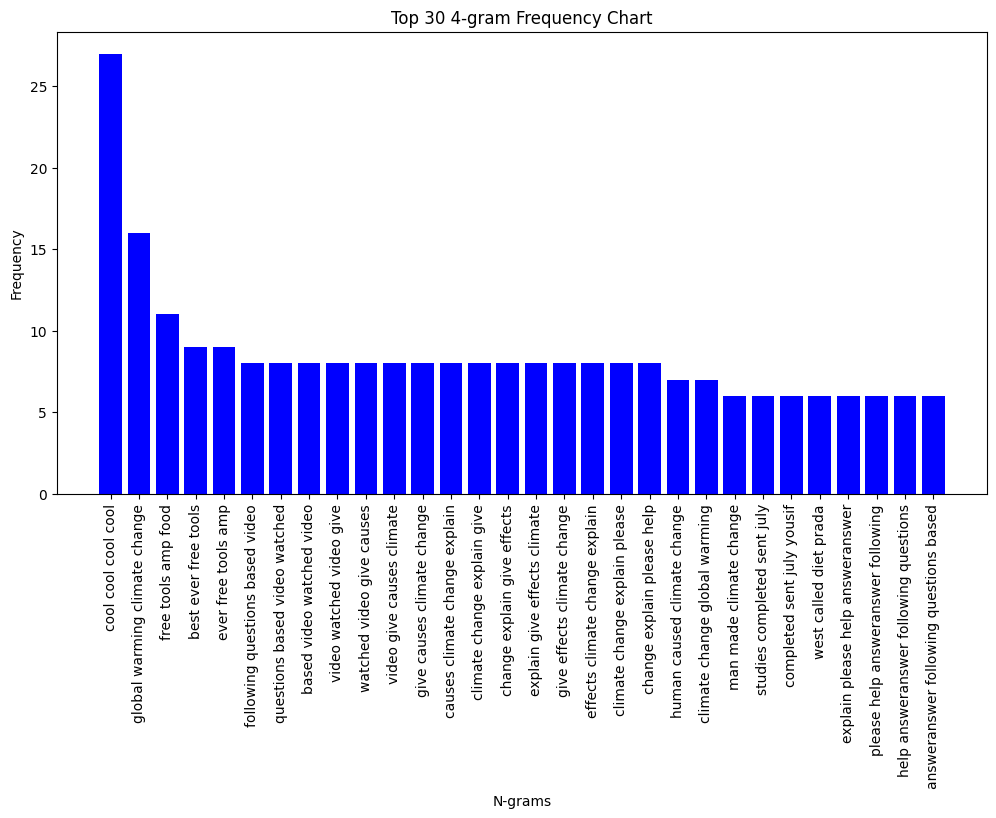

In [55]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
long_text = ",".join(list(df["comment"].values))

def preprocess_text(text):
    # Remove unwanted characters and patterns
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'https://\S+', '', text)
    text = re.sub(r'DOI: \S+', '', text)
    text = re.sub(r'et al\.\S+', '', text)
    text = text.strip()
    text = re.sub('[,\.!?]', '', text)
    
    # Tokenize and remove stopwords
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens
def plot_ngram_frequencies(text, n, top_k=5):
    # Preprocess the text
    tokens = preprocess_text(text)
    
    # Generate n-grams with progress bar
    n_grams = []
    for i in tqdm(range(len(tokens) - n + 1), desc="Generating n-grams"):
        n_grams.append(tuple(tokens[i:i + n]))
    
    # Calculate frequency with progress bar
    ngram_freq = Counter()
    for ngram in tqdm(n_grams, desc="Counting n-grams frequency"):
        ngram_freq[ngram] += 1
    
    # Prepare data for plotting with progress bar
    ngram_labels = []
    ngram_values = []
    for gram, freq in tqdm(ngram_freq.items(), desc="Preparing data for plotting"):
        ngram_labels.append(' '.join(gram))
        ngram_values.append(freq)
    
    # Sort the n-grams by frequency and select top_k
    sorted_ngrams = sorted(zip(ngram_labels, ngram_values), key=lambda x: x[1], reverse=True)[:top_k]
    ngram_labels, ngram_values = zip(*sorted_ngrams)
     # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(ngram_labels, ngram_values, color='blue')
    plt.xlabel('N-grams')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_k} {n}-gram Frequency Chart')
    plt.xticks(rotation=90)
    plt.show()

text=long_text

# Example usage
n = 4  # Change n to 1, 2, 3, or 4 as needed
top_k = 30  # Change top_k to 5, 6, or 7 as needed
plot_ngram_frequencies(text, n, top_k)

In [7]:
pip install googletrans==4.0.0-rc1


Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
from collections import Counter
import re

# Sample DataFrame
df = pd.read_csv("youtube_comments.csv")

# Combine all comments into a single text
all_comments = ' '.join(df['comment'].tolist())

# Tokenize the text into words (you can modify the regex for better tokenization)
words = re.findall(r'\b\w+\b', all_comments.lower())

# Count the frequency of each word
word_counts = Counter(words)

# Specify the word to count
word_to_count = input('Enter word whose frequency u want to see.\n')
frequency = word_counts[word_to_count]

# Display the frequency
print(f"The word '{word_to_count}' appears {frequency} times.")


Enter word whose frequency u want to see.
 snow


The word 'snow' appears 72 times.


In [ ]:
### import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame


# Combine all comments into a single text
all_comments = ' '.join(df['comment'].tolist())

# Tokenize the text into words (you can modify the regex for better tokenization)
words = re.findall(r'\b\w+\b', all_comments.lower())

# Count the frequency of each word
word_counts = Counter(words)

# Convert to DataFrame for easier plotting
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

# Display the top words
print(word_freq_df.head(10))

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', data=word_freq_df.head(10), palette='viridis')
plt.title('Top 10 Word Frequencies in Comments')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()



In [1]:
pip install beautifulsoup4 lxml


   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   -- ------------------------------------- 0.3/3.8 MB ? eta -:--:--
   ---------- ----------------------------- 1.0/3.8 MB 6.3 MB/s eta 0:00:01
   ------------- -------------------------- 1.3/3.8 MB 3.7 MB/s eta 0:00:01
   --------------------- ------------------ 2.1/3.8 MB 2.7 MB/s eta 0:00:01
   --------------------- ------------------ 2.1/3.8 MB 2.7 MB/s eta 0:00:01
   ------------------------------ --------- 2.9/3.8 MB 2.4 MB/s eta 0:00:01
   ------------------------------ --------- 2.9/3.8 MB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 3.8/3.8 MB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [43]:
def get_sentiment(comment):
    analysis = TextBlob(comment)
    # Determine polarity
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

# Apply sentiment function to the comments
df['sentiment'] = df['comment'].apply(get_sentiment)

# Calculate percentages
sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100

# Display results
print(sentiment_counts)


sentiment
positive    42.165347
neutral     33.782913
negative    24.051740
Name: proportion, dtype: float64


In [56]:
!pip install gensim nltk
import pandas as pd
import nltk
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LdaModel

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Sample DataFrame (replace this with your actual DataFrame)
df = pd.read_csv("C:/Users/zobey/Downloads/youtube_comments 130000.csv")

# Preprocess the comments
def preprocess(text):
    # Tokenization
    tokens = text.lower().split()
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Apply preprocessing
df['tokens'] = df['comment'].apply(preprocess)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Train the LDA model
num_topics = 5  # Specify the number of topics
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zobey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 0: 0.010*"trump" + 0.006*"class" + 0.006*"war" + 0.005*"fake" + 0.005*"predictions" + 0.004*"forest" + 0.003*"yeah" + 0.003*"الله" + 0.003*"ukraine" + 0.003*"gaza"
Topic 1: 0.021*"people" + 0.010*"like" + 0.009*"going" + 0.009*"us" + 0.008*"know" + 0.008*"think" + 0.008*"world" + 0.008*"video" + 0.008*"make" + 0.007*"get"
Topic 2: 0.021*"earth" + 0.016*"global" + 0.012*"climate" + 0.011*"warming" + 0.010*"ice" + 0.009*"temperature" + 0.009*"years" + 0.008*"water" + 0.006*"heat" + 0.006*"humans"
Topic 3: 0.011*"people" + 0.011*"like" + 0.009*"years" + 0.006*"trump" + 0.006*"still" + 0.004*"get" + 0.004*"us" + 0.004*"thanks" + 0.004*"vox" + 0.004*"usa"
Topic 4: 0.047*"climate" + 0.033*"change" + 0.008*"need" + 0.008*"fossil" + 0.008*"stop" + 0.007*"global" + 0.006*"energy" + 0.006*"carbon" + 0.006*"one" + 0.005*"human"


In [57]:
import langchain_community

from langchain_community.document_loaders import PyMuPDFLoader
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import os
import re
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess

from nltk.corpus import stopwords
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle
import spacy
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import fitz
from keybert import KeyBERT
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zobey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zobey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
df = pd.read_csv("C:/Users/zobey/Downloads/youtube_comments 130000.csv")
def get_comment_contents(df):
    # Check if the DataFrame contains the 'comment' column
    if 'comment' not in df.columns:
        raise ValueError("The DataFrame must contain a 'comment' column.")
    
    # Extract contents of the 'comment' column
    comment_contents = df['comment'].tolist()
    
    return comment_contents

# Example usage
# Assuming 'df' is your DataFrame containing the 'comment' column
comment_contents = get_comment_contents(df)


In [59]:
#Preprocessing of Text

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
more_stopwords = [
    'call', 'upon', 'still', 'nevertheless', 'down', 'every', 'forty', '‘re', 'always', 'whole', 'side', "n't", 'now',
    'however', 'an', 'show', 'least', 'give', 'below', 'did', 'sometimes', 'which', "'s", 'nowhere', 'per', 'hereupon',
    'yours', 'she', 'moreover', 'eight', 'somewhere', 'within', 'whereby', 'few', 'has', 'so', 'have', 'for', 'noone',
    'top', 'were', 'those', 'thence', 'eleven', 'after', 'no', '’ll', 'others', 'ourselves', 'themselves', 'though',
    'that', 'nor', 'just', '’s', 'before', 'had', 'toward', 'another', 'should', 'herself', 'and', 'these', 'such',
    'elsewhere', 'further', 'next', 'indeed', 'bottom', 'anyone', 'his', 'each', 'then', 'both', 'became', 'third',
    'whom', '‘ve', 'mine', 'take', 'many', 'anywhere', 'to', 'well', 'thereafter', 'besides', 'almost', 'front',
    'fifteen', 'towards', 'none', 'be', 'herein', 'two', 'using', 'whatever', 'please', 'perhaps', 'full', 'ca', 'we',
    'latterly', 'here', 'therefore', 'us', 'how', 'was', 'made', 'the', 'or', 'may', '’re', 'namely', "'ve", 'anyway',
    'amongst', 'used', 'ever', 'of', 'there', 'than', 'why', 'really', 'whither', 'in', 'only', 'wherein', 'last',
    'under', 'own', 'therein', 'go', 'seems', '‘m', 'wherever', 'either', 'someone', 'up', 'doing', 'on', 'rather',
    'ours', 'again', 'same', 'over', '‘s', 'latter', 'during', 'done', "'re", 'put', "'m", 'much', 'neither', 'among',
    'seemed', 'into', 'once', 'my', 'otherwise', 'part', 'everywhere', 'never', 'myself', 'must', 'will', 'am', 'can',
    'else', 'although', 'as', 'beyond', 'are', 'too', 'becomes', 'does', 'a', 'everyone', 'but', 'some', 'regarding',
    '‘ll', 'against', 'throughout', 'yourselves', 'him', "'d", 'it', 'himself', 'whether', 'move', '’m', 'hereafter',
    're', 'while', 'whoever', 'your', 'first', 'amount', 'twelve', 'serious', 'other', 'any', 'off', 'seeming', 'four',
    'itself', 'nothing', 'beforehand', 'make', 'out', 'very', 'already', 'various', 'until', 'hers', 'they', 'not',
    'them', 'where', 'would', 'since', 'everything', 'at', 'together', 'yet', 'more', 'six', 'back', 'with',
    'thereupon', 'becoming', 'around', 'due', 'keep', 'somehow', 'n‘t', 'across', 'all', 'when', 'i', 'empty', 'nine',
    'five', 'get', 'see', 'been', 'name', 'between', 'hence', 'ten', 'several', 'from', 'whereupon', 'through',
    'hereby', "'ll", 'alone', 'something', 'formerly', 'without', 'above', 'onto', 'except', 'enough', 'become',
    'behind', '’d', 'its', 'most', 'n’t', 'might', 'whereas', 'anything', 'if', 'her', 'via', 'fifty', 'is',
    'thereby', 'twenty', 'often', 'whereafter', 'their', 'also', 'anyhow', 'cannot', 'our', 'could', 'because', 'who',
    'beside', 'by', 'whence', 'being', 'meanwhile', 'this', 'afterwards', 'whenever', 'mostly', 'what', 'one', 'nobody',
    'seem', 'less', 'do', '‘d', 'say', 'thus', 'unless', 'along', 'yourself', 'former', 'thru', 'he', 'hundred', 'three',
    'sixty', 'me', 'sometime', 'whose', 'you', 'quite', '’ve', 'about', 'even', '0', '1', '2', '3', '4', '5', '6', '7',
    '8', '9', 'a', 'A', 'about', 'above', 'across', 'after', 'again', 'against', 'all', 'almost', 'alone', 'along',
    'already', 'also', 'although', 'always', 'am', 'among', 'an', 'and', 'another', 'any', 'anyone', 'anything',
    'anywhere', 'are', "aren't", "around", "as", "at", 'b', 'B', "back", "be", "became", "because", "become",
    'becomes', 'been', 'before', 'behind', 'being', 'below', 'between', 'both', 'but', 'by', 'c', 'C', 'can', 'cannot',
    "can't", 'could', "couldn't", 'd', 'D', 'did', "didn't", 'do', 'does', "doesn't", 'doing', 'done', "don't", 'down',
    'during', 'e', 'E', 'each', 'either', 'enough', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere',
    'f', 'F', 'few', 'find', 'first', 'for', 'four', 'from', 'full', 'further', 'g', 'G', 'get', 'give', 'go', 'h', 'H',
    'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', "here's",
    'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'however', "how's", 'i', 'I', "i'd", 'if', "i'll", "i'm",
    'in', 'interest', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "i've", 'j', 'J', 'k', 'K', 'keep', 'l', 'L',
    'last', 'least', 'less', "let's", 'm', 'M', 'made', 'many', 'may', 'me', 'might', 'more', 'most', 'mostly', 'much',
    'must', "mustn't", 'my', 'myself', 'n', 'N', 'never', 'next', 'no', 'nobody', 'noone', 'nor', 'not', 'nothing',
    'now', 'nowhere', 'o', 'O', 'of', 'off', 'often', 'on', 'once', 'one', 'only', 'or', 'other', 'others', 'ought',
    'our', 'ours', 'ourselves', 'out', 'over', 'own', 'p', 'P', 'part', 'per', 'perhaps', 'put', 'q', 'Q', 'r', 'R',
    'rather', 's', 'S', 'same', 'see', 'seem', 'seemed', 'seeming', 'seems', 'several', "shan't", 'she', "she'd",
    "she'll", "she's", 'should', "shouldn't", 'show', 'side', 'since', 'so', 'some', 'someone', 'something',
    'somewhere', 'still', 'such', 't', 'T', 'take', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them',
    'themselves', 'then', 'there', 'therefore', "there's", 'these', 'they', "they'd", "they'll", "they're", "they've",
    'this', 'those', 'though', 'three', 'through', 'thus', 'to', 'together', 'too', 'toward', 'two', 'u', 'U', 'under',
    'until', 'up', 'upon', 'us', 'v', 'V', 'very', 'w', 'W', 'was', "wasn't", 'we', "we'd", "we'll", 'well', "we're",
    'were', "weren't", "we've", 'what', "what's", 'when', "when's", 'where', "where's", 'whether', 'which', 'while',
    'who', 'whole', 'whom', "who's", 'whose', 'why', "why's", 'will', 'with', 'within', 'without', "won't", 'would',
    "wouldn't", 'x', 'X', 'y', 'Y', 'yet', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves',
    "you've", 'z', 'Z', "al", "et", "vol", "pp", "time", "ieee", "traf", "new"
]
for words in more_stopwords:
    stop_words.append(words)

def preprocess_text(text):
    # Remove unwanted characters and patterns
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'https://\S+', '', text)
    text = re.sub(r'DOI: \S+', '', text)
    text = re.sub(r'et al\.\S+', '', text)
    text = text.strip()
    text = re.sub('[,\.!?]', '', text)

    # Tokenize and remove stopwords
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

In [60]:
import pandas as pd
import numpy as np
import re
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm

# Initialize KeyBERT model and embedding model
kw_model = KeyBERT()
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = text.strip()
    text = re.sub('[,\.!?]', '', text)
    return text

def preprocess_comments(df):
    if 'comment' not in df.columns:
        raise ValueError("The DataFrame must contain a 'comment' column.")
    
    df['comment'] = df['comment'].apply(lambda x: preprocess_text(x).lower())
    return df

def extract_keywords(text, top_k=10):
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 2),
        stop_words='english',  # Use default English stop words
        top_n=top_k
    )
    return [kw[0] for kw in keywords]

def cluster_keywords(keywords, n_clusters=10):
    if len(keywords) == 0:
        return []

    embeddings = embedding_model.encode(keywords)

    # Perform Agglomerative Clustering
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters)
    clustering_model.fit(embeddings)
    cluster_labels = clustering_model.labels_

    clustered_keywords = {}
    for keyword, label in zip(keywords, cluster_labels):
        if label not in clustered_keywords:
            clustered_keywords[label] = keyword

    return list(clustered_keywords.values())

def process_comments_and_extract_keywords(df, top_k=10, n_clusters=10):
    # Step 1: Preprocess Comments
    df = preprocess_comments(df)

    # Combine all comments into one long string
    long_text = ' '.join(df['comment'].tolist())

    # Step 2: Extract Keywords
    keywords = extract_keywords(long_text, top_k=top_k * 3)

    # Step 3: Cluster Keywords
    clustered_keywords = cluster_keywords(keywords, n_clusters=n_clusters)
    print("\nClustered Keywords:\n", clustered_keywords)

    return clustered_keywords

# Example usage
# Assuming 'df' is your DataFrame containing the 'comment' column
clustered_keywords = process_comments_and_extract_keywords(df)



Clustered Keywords:
 ['european emissions', 'eu achieving', 'flood eu', 'eu industry', 'eu forcing', 'environment gdp', 'eu mining', 'claimed climate', 'europe doomed', 'climate greed']


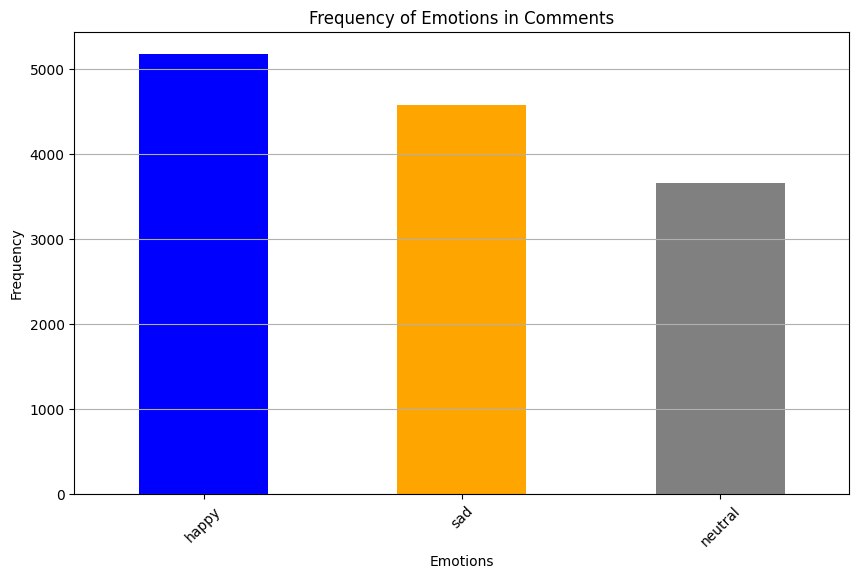

In [61]:
df = pd.read_csv("youtube_comments.csv")
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Analyze emotions
def get_emotion(comment):
    score = sia.polarity_scores(comment)
    if score['compound'] >= 0.05:
        return 'happy'
    elif score['compound'] <= -0.05:
        return 'sad'
    else:
        return 'neutral'

# Apply the emotion function to the 'comment' column
df['emotion'] = df['comment'].apply(get_emotion)

# Count frequencies of emotions
emotion_counts = df['emotion'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color=['blue', 'orange', 'gray'])
plt.title('Frequency of Emotions in Comments')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()



In [8]:
df = pd.read_csv("youtube_comments.csv")
import pandas as pd

# Assuming you have a DataFrame df
# Filter rows where the 'comment' column contains the word "climate"
filtered_df = df[df['comment'].str.contains('EU', case=False, na=False)]

# Display the filtered rows
print(filtered_df)

       Unnamed: 0     video_id  \
5               5  6ipKY5xqiec   
6               6  6ipKY5xqiec   
21             21  6ipKY5xqiec   
26             26  6ipKY5xqiec   
32             32  6ipKY5xqiec   
...           ...          ...   
13203       13203  sDS1sFg6lNw   
13276       13276  sDS1sFg6lNw   
13277       13277  sDS1sFg6lNw   
13313       13313  sDS1sFg6lNw   
13350       13350  sDS1sFg6lNw   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [9]:
import pandas as pd
from textblob import TextBlob

df = pd.read_csv("youtube_comments.csv")

# Function to calculate subjectivity score using TextBlob
def get_subjectivity(comment):
    blob = TextBlob(comment)
    return blob.sentiment.subjectivity

# Apply the function to the 'comment' column and create a new 'subjectivity' column
df['subjectivity'] = df['comment'].apply(get_subjectivity)

# Print the DataFrame with the subjectivity score
print(df)


       Unnamed: 0     video_id  \
0               0  6ipKY5xqiec   
1               1  6ipKY5xqiec   
2               2  6ipKY5xqiec   
3               3  6ipKY5xqiec   
4               4  6ipKY5xqiec   
...           ...          ...   
13407       13407  sDS1sFg6lNw   
13408       13408  sDS1sFg6lNw   
13409       13409  sDS1sFg6lNw   
13410       13410  sDS1sFg6lNw   
13411       13411  sDS1sFg6lNw   

                                                                                                                                                                          comment  \
0                                                                                                               VW is already in jeopardy but they don&#39;t realize that really.   
1      The floods in Spain are just the latest - they deposit the alluvium that the city and its suburbs are built on! They&#39;ve happened for thousands and thousands of years.   
2                                               

In [10]:
mean_subjectivity = df['subjectivity'].mean()

# Print the mean subjectivity score
print("Mean Subjectivity Score:", mean_subjectivity)

Mean Subjectivity Score: 0.3486312962810394


In [62]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Sample DataFrame (replace with your actual DataFrame)
df = pd.read_csv("youtube_comments.csv")
# Initialize the SentimentIntensityAnalyzer from vaderSentiment
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores using VADER
def get_vader_sentiment(comment):
    sentiment = analyzer.polarity_scores(comment)
    return sentiment

# Apply the function to the 'comment' column and create new sentiment columns
df['vader_sentiment'] = df['comment'].apply(get_vader_sentiment)

# Expand the sentiment columns (positive, neutral, negative, compound)
df = pd.concat([df, df['vader_sentiment'].apply(pd.Series)], axis=1)

# Print the DataFrame with sentiment analysis results
print(df)


       Unnamed: 0     video_id  \
0               0  6ipKY5xqiec   
1               1  6ipKY5xqiec   
2               2  6ipKY5xqiec   
3               3  6ipKY5xqiec   
4               4  6ipKY5xqiec   
...           ...          ...   
13407       13407  sDS1sFg6lNw   
13408       13408  sDS1sFg6lNw   
13409       13409  sDS1sFg6lNw   
13410       13410  sDS1sFg6lNw   
13411       13411  sDS1sFg6lNw   

                                                 comment  \
0      VW is already in jeopardy but they don&#39;t r...   
1      The floods in Spain are just the latest - they...   
2       Copernicus confirmed today that 1.5 is exceeded.   
3      FINALLY........a chance for the truth to come ...   
4      concept of climate change? belief of/in people...   
...                                                  ...   
13407  I can very much see both Climate Change and Gl...   
13408  Thank you for the simple, clear and crisp desc...   
13409  Thank you for the information. Si beautifull

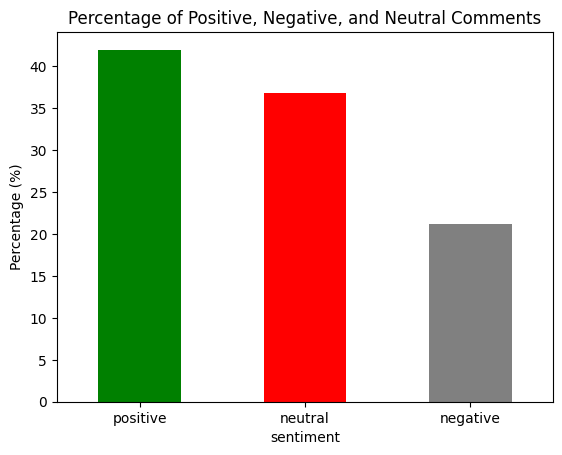

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob





# Function to classify the sentiment of a comment
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment function to the 'comment' column
df['sentiment'] = df['comment'].apply(get_sentiment)

# Calculate percentage of positive, negative, and neutral comments
sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100

# Plot the results
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Percentage of Positive, Negative, and Neutral Comments')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.show()


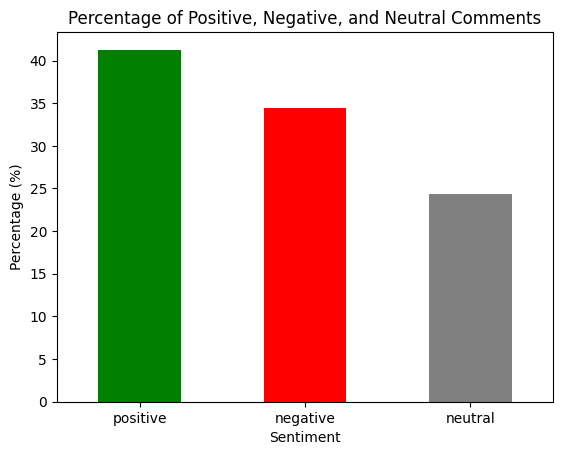

sentiment
positive    41.269013
negative    34.387116
neutral     24.343871
Name: proportion, dtype: float64


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

df = pd.read_csv("youtube_comments.csv")

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment based on VADER's compound score
def get_vader_sentiment(text):
    # Get sentiment scores from VADER
    sentiment_scores = analyzer.polarity_scores(text)
    
    # Extract the compound score
    compound_score = sentiment_scores['compound']
    
    # Classify the sentiment based on the compound score
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to classify each comment
df['sentiment'] = df['comment'].apply(get_vader_sentiment)

# Calculate the percentage of positive, negative, and neutral comments
sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100

# Plot the results
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Percentage of Positive, Negative, and Neutral Comments')
plt.ylabel('Percentage (%)')
plt.xlabel('Sentiment')
plt.xticks(rotation=0)
plt.show()

# Display the sentiment counts (optional)
print(sentiment_counts)
